In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/DL-ROMs/APSC_project/bayesian_network"

/content/drive/MyDrive/Colab Notebooks/DL-ROMs/APSC_project/bayesian_network


In [ ]:
try:
    from dlroms import *
except:
    !pip install git+https://github.com/NicolaRFranco/dlroms.git
    from dlroms import *

In [ ]:
from dlroms import *
from dlroms.gp import GaussianRandomField
# from geogp import GaussianRandomField
import numpy as np
from dolfin import *
from IPython.display import clear_output as clc

### Setup

FE space dimension: 1225


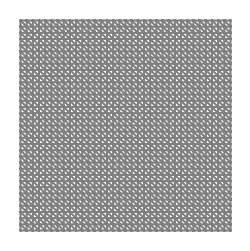

In [ ]:
# Domain definition

# domain = fe.circle((0.0, 0.0), 1) - fe.circle((0.0, 0.0), 0.4)
domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) # - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.03)
V = fe.space(mesh, 'CG', 1)
clc()

plt.figure(figsize=(3, 3))
fe.plot(mesh)

print('FE space dimension:', V.dim())

In [ ]:
# Input random field definition

l = 0.1 # length scale
m = 0.0 # kernel mean
# ker = lambda r: np.exp(- (r - m) ** 2 / l)
ker = lambda r: np.exp(- np.abs(r - m) / l)
KLE_dims = [10, 50, 500, 4255]
K = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[0]) # dlrom version # Euclidean version
# K_geo = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[0], domain=domain) # dlrom version # geodesic version (geodesic_accuracy?) # KeyError: 'stepsize'
# K = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[1]) # geogp version # Euclidean version
clc()

In [ ]:
test_sample = K.sample(0)
# test_sample = K_geo.sample(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_sample.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1225,)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


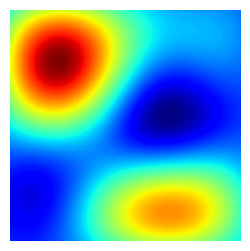

In [ ]:
plt.figure(figsize=(3, 3))
fe.plot(test_sample, V, cmap='jet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


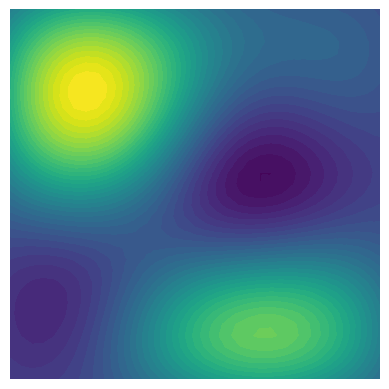

In [ ]:
# As a function
k = Function(V)
k.vector()[:] = K.sample(0)
fe.plot(k)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


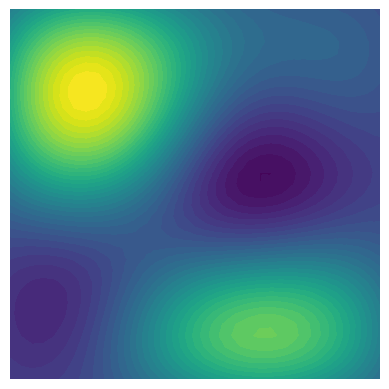

In [ ]:
# As an expression
class Field(UserExpression):
    def __init__(self, field, **kwargs):
        self.field = field
        super().__init__(**kwargs)

    def eval(self, values, x):
        k = Function(V)
        k.vector()[:] = self.field
        values[0] = k(x)

    def value_shape(self):
        return ()

k = Field(K.sample(0), degree=1)
k_eval = interpolate(k, V)
fe.plot(k_eval)

In [ ]:
V0 = fe.space(mesh, 'DG', 0)
clc()

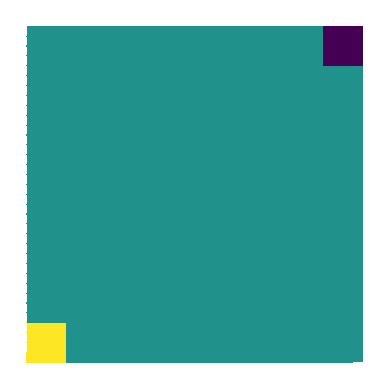

In [ ]:
# Injection term
r = 10 # source rate
w = 0.125 # source size

class Injection(UserExpression):
    def __init__(self, w, r, **kwargs):
        self.w = w
        self.r = r
        super().__init__(**kwargs)

    def eval(self, values, x):
        if abs(x[0] - 0.5 * self.w) <= 0.5 * self.w and abs(x[1] - 0.5 * self.w) <= 0.5 * self.w:
            values[0] = self.r
        elif abs(x[0] + 0.5 * self.w - 1) <= 0.5 * self.w and abs(x[1] + 0.5 * self.w - 1) <= 0.5 * self.w:
            values[0] = - self.r
        else:
            values[0] = 0

    def value_shape(self):
        return ()

f = Injection(w, r, degree=0) # f only takes constant values
f_eval = interpolate(f, V0)
fe.plot(f_eval)

### Darcy flow

The Darcy flow equation is solved using **mixed finite elements** with third-order Raviart-Thomas elements for the velocity, and fourth-order discontinuous elements for the pressure.

In [ ]:
# Snapshots generation

def Darcy(K, mesh):
    """
    Solve the Darcy problem for a given instance of the input random field.
    Args:
        K, input random field
        V, FE space for the input random field
        mesh, input mesh
    """
    r = 10 # source rate
    w = 0.125 # source size

    # Function spaces
    # RT = FunctionSpace(mesh, "RT", 3)
    # DG = FunctionSpace(mesh, "DG", 4)
    # W  = MixedFunctionSpace([RT, DG]) # DEPRECATED
    RT_elem = FiniteElement("RT", mesh.ufl_cell(), 3)
    DG_elem = FiniteElement("DG", mesh.ufl_cell(), 4)
    R_elem = FiniteElement("R", mesh.ufl_cell(), 0) # real number for Lagrange multiplier
    W_elem = MixedElement([RT_elem, DG_elem, R_elem])
    W = FunctionSpace(mesh, W_elem) # mixed function space

    # print('Function space dimension:', W.dim()) # 59161
    # print(W.sub(0).dim(), W.sub(1).dim(), W.sub(2).dim()) # 24480 34680 1

    # Trial and test functions
    u, p, mu = TrialFunctions(W)
    v, q, nu = TestFunctions(W)

    # Injection term
    class Injection(UserExpression):
        def __init__(self, w, r, **kwargs):
            self.w = w
            self.r = r
            super().__init__(**kwargs)

        def eval(self, values, x):
            if abs(x[0] - 0.5 * self.w) <= 0.5 * self.w and abs(x[1] - 0.5 * self.w) <= 0.5 * self.w:
                values[0] = self.r
            elif abs(x[0] + 0.5 * self.w - 1) <= 0.5 * self.w and abs(x[1] + 0.5 * self.w - 1) <= 0.5 * self.w:
                values[0] = - self.r
            else:
                values[0] = 0

        def value_shape(self):
            return ()

    f = Injection(w, r, degree=0) # f only takes constant values

    # Gaussian field
    class Field(UserExpression):
        def __init__(self, field, **kwargs):
            self.field = field
            super().__init__(**kwargs)

        def eval(self, values, x):
            # values[0] = interpolate(x[0], x[1], mesh.coordinates(), self.field)
            V = fe.space(mesh, 'CG', 1)
            k = Function(V)
            k.vector()[:] = self.field
            values[0] = k(x)

        def value_shape(self):
            return ()

    # Gaussian random field as an expression
    k = Field(K.sample(100), degree=1)

    # Variational problem
    # a = (dot(u, v) - p * div(k * v) - dot(u, grad(q))) * dx
    a = (dot(u, v) + k * dot(grad(p), v) - dot(u, grad(q)) + mu * q + p * nu) * dx
    L = f * q * dx

    def boundary(x):
      return x[0] == 0.0 or x[0] == 1.0 or x[1] == 0.0 or x[1] == 1.0

    # No-flux boundary condition for velocity
    bc = DirichletBC(W.sub(0), Constant((0, 0)), boundary)

    w = Function(W)
    solve(a == L, w, bc)
    # solve(a == L, w)
    u, p, mu = w.split()

    # Correct NaN values
    # u.vector().set_local(np.nan_to_num(u.vector().get_local()))
    # p.vector().set_local(np.nan_to_num(p.vector().get_local()))

    return u, p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# mesh = fe.mesh(domain, stepsize=0.03) # stepsize=0.01: takes too long to run (> 15 min)
mesh = fe.mesh(domain, stepsize=0.05)

l = 0.1 # length scale
m = 0.0 # kernel mean

# ker = lambda r: np.exp(- (r - m) ** 2 / l)
ker = lambda r: np.exp(- np.abs(r - m) / l)
KLE_dims = [10, 50, 500, 4255]

K = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[1]) # dlrom version # Euclidean version

u, p = Darcy(K, mesh)
clc()

In [ ]:
# count nans
print(np.isnan(p.vector().get_local()).sum())
print(len(p.vector().get_local()))

8283
20521


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


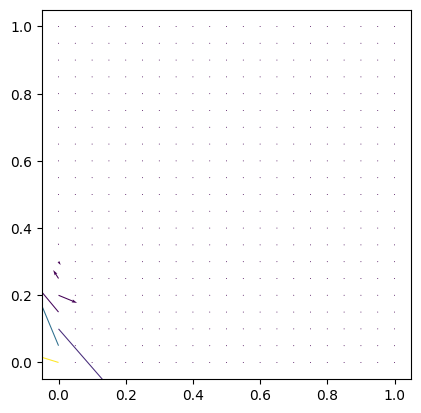

In [ ]:
# RT = FunctionSpace(mesh, "RT", 3)
# RT_x = RT.sub(0).collapse()
# u_x = interpolate(u.sub(0), RT_x)
# u_x = u.sub(0, deepcopy=True)
plot(u)

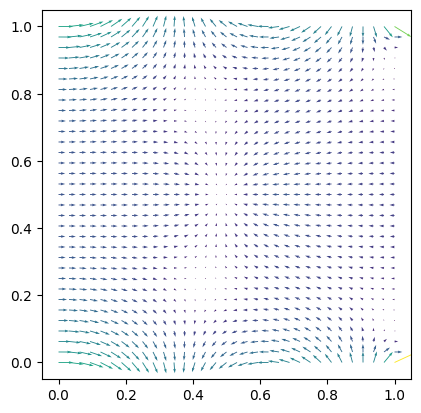

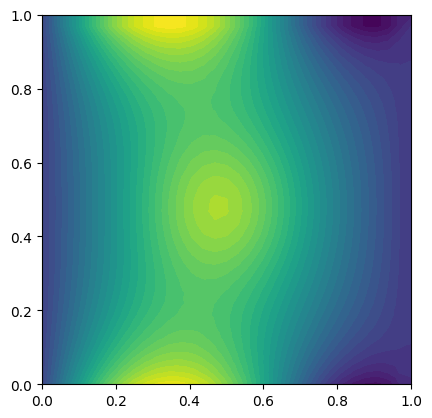

In [ ]:
# Implementation
# --------------
#
# This demo is implemented in the :download:`demo_mixed-poisson.py`
# file.
#
# First, the required modules are imported::

from dolfin import *
import matplotlib.pyplot as plt

# Then, we need to create a :py:class:`Mesh <dolfin.cpp.Mesh>` covering
# the unit square. In this example, we will let the mesh consist of 32 x
# 32 squares with each square divided into two triangles::

# Create mesh
mesh = UnitSquareMesh(32, 32)

# .. index::
#    pair: FunctionSpace; Brezzi-Douglas-Marini
#    pair: FunctionSpace; Discontinous Lagrange
#
# Next, we need to build the function space. ::

# Define finite elements spaces and build mixed space
BDM = FiniteElement("BDM", mesh.ufl_cell(), 1)
DG  = FiniteElement("DG", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, BDM * DG)

# The second argument to :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` specifies underlying
# finite element, here mixed element obtained by ``*`` operator.
#
# .. math::
#
#     W = \{ (\tau, v) \ \text{such that} \ \tau \in BDM, v \in DG \}.
#
# Next, we need to specify the trial functions (the unknowns) and the
# test functions on this space. This can be done as follows::

# Define trial and test functions
(sigma, u) = TrialFunctions(W)
(tau, v) = TestFunctions(W)

# In order to define the variational form, it only remains to define the
# source function :math:`f`. This is done just as for the :ref:`Poisson
# demo <demo_poisson_equation>`::

# Define source function
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)

# We are now ready to define the variational forms a and L. Since,
# :math:`u_0 = 0` in this example, the boundary term on the right-hand
# side vanishes. ::

# Define variational form
a = (dot(sigma, tau) + div(tau)*u + div(sigma)*v)*dx
L = - f*v*dx

# It only remains to prescribe the boundary condition for the
# flux. Essential boundary conditions are specified through the class
# :py:class:`DirichletBC <dolfin.fem.bcs.DirichletBC>` which takes three
# arguments: the function space the boundary condition is supposed to be
# applied to, the data for the boundary condition, and the relevant part
# of the boundary.
#
# We want to apply the boundary condition to the first subspace of the
# mixed space. Subspaces of a mixed :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` can be accessed
# by the method :py:func:`sub
# <dolfin.functions.functionspace.FunctionSpace.sub>`. In our case,
# this reads ``W.sub(0)``. (Do *not* use the separate space ``BDM`` as
# this would mess up the numbering.)
#
# Next, we need to construct the data for the boundary condition. An
# essential boundary condition is handled by replacing degrees of
# freedom by the degrees of freedom evaluated at the given data. The
# :math:`BDM` finite element spaces are vector-valued spaces and hence
# the degrees of freedom act on vector-valued objects. The effect is
# that the user is required to construct a :math:`G` such that :math:`G
# \cdot n = g`.  Such a :math:`G` can be constructed by letting :math:`G
# = g n`. In particular, it can be created by subclassing the
# :py:class:`Expression <dolfin.functions.expression.Expression>`
# class. Overloading the ``eval_cell`` method (instead of the usual
# ``eval``) allows us to extract more geometry information such as the
# facet normals. Since this is a vector-valued expression, we also need
# to overload the ``value_shape`` method.
#
# .. index::
#    single: Expression; (in Mixed Poisson demo)
#
# ::

# Define function G such that G \cdot n = g
class BoundarySource(UserExpression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        super().__init__(**kwargs)
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        g = sin(5*x[0])
        values[0] = g*n[0]
        values[1] = g*n[1]
    def value_shape(self):
        return (2,)

G = BoundarySource(mesh, degree=2)

# Specifying the relevant part of the boundary can be done as for the
# Poisson demo (but now the top and bottom of the unit square is the
# essential boundary): ::

# Define essential boundary
def boundary(x):
    return x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS

# Now, all the pieces are in place for the construction of the essential
# boundary condition: ::

bc = DirichletBC(W.sub(0), G, boundary)

# To compute the solution we use the bilinear and linear forms, and the
# boundary condition, but we also need to create a :py:class:`Function
# <dolfin.functions.function.Function>` to store the solution(s). The
# (full) solution will be stored in the ``w``, which we initialise using
# the :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` ``W``. The actual
# computation is performed by calling :py:func:`solve
# <dolfin.fem.solving.solve>`. The separate components ``sigma`` and
# ``u`` of the solution can be extracted by calling the :py:func:`split
# <dolfin.functions.function.Function.split>` function. Finally, we plot
# the solutions to examine the result. ::

# Compute solution
w = Function(W)
solve(a == L, w, bc)
(sigma, u) = w.split()
clc()

# Plot sigma and u
plt.figure()
plot(sigma)

plt.figure()
plot(u)

plt.show()